# This tutorial shows how to run Cytocraft on subcell-resolution ST data (MERFISH ileum dataset)

## Preprocessing

### Load packages

In [1]:
import os
import pandas as pd
import cytocraft.craft as cc
gem_path = './demo/merfish_ileum/data/transcripts.gem.csv'
obs_path = './demo/merfish_ileum/data/cell_feature.csv'

### Read gene expression matrix file and corresponding cell meta file of ST

In [2]:
gem = cc.read_gem_as_csv(gem_path, sep=',')

In [3]:
gem

,CellID,x,y,geneID,MIDCount
0,1,1705,1271,Maoa,1.0
1,2,1725,1922,Maoa,1.0
2,2,1753,1863,Maoa,1.0
3,2,1760,1865,Maoa,1.0
4,3,1904,794,Maoa,1.0
...,...,...,...,...,...
819660,1365,5704,38,Hrh1,1.0
819661,1365,5685,43,Htr4,1.0
819662,1365,5631,61,Taar6,1.0
819663,1365,5720,62,Taar7a,1.0


In [4]:
obs = pd.read_csv(obs_path, sep=',')
# remove the removed cells
obs=obs[obs['leiden_final']!='Removed']

In [5]:
obs

,cell,x,y,n_transcripts,density,elongation,area,avg_confidence,leiden_final
0,1,2072.205128,16.128205,39,0.021590,5.082,1806.0,0.8647,Endothelial
1,2,2150.690909,41.678788,165,0.020160,1.565,8186.0,0.9528,Smooth Muscle
2,3,2079.841727,76.071942,139,0.022790,1.820,6100.0,0.9762,Smooth Muscle
3,4,2092.325000,165.762500,80,0.018280,1.546,4376.0,0.9076,Smooth Muscle
4,5,2242.400000,18.280000,75,0.024790,3.475,3025.0,0.8952,Smooth Muscle
...,...,...,...,...,...,...,...,...,...
5766,5767,4780.526316,3869.684211,19,0.026550,3.860,715.5,0.9513,Enterocyte (Top Villus)
5770,5771,3787.700000,583.300000,10,0.009294,2.028,1076.0,0.9421,Enterocyte (Mid Villus)
5779,5780,5222.615385,8772.846154,13,0.014170,16.760,917.5,0.9312,Stem + TA
5781,5782,3443.093750,6169.906250,32,0.010670,6.223,2998.0,0.9591,Enterocyte (Mid Villus)


### Splitting gem files based on the cell type of the meta file

In [6]:
print(obs.columns)
# keys are from obs column indeces
ct_key = 'leiden_final'
ci_key = 'cell'
split_paths = cc.split_gem(gem_path, obs, ct_key, ci_key, gsep=',')

Index(['cell', 'x', 'y', 'n_transcripts', 'density', 'elongation', 'area',
       'avg_confidence', 'leiden_final'],
      dtype='object')
split gem path of Endothelial: ./demo/merfish_ileum/data/transcripts.gem.csv.leiden_final.Endothelial.tsv
split gem path of Smooth Muscle: ./demo/merfish_ileum/data/transcripts.gem.csv.leiden_final.Smooth_Muscle.tsv
split gem path of Telocyte: ./demo/merfish_ileum/data/transcripts.gem.csv.leiden_final.Telocyte.tsv
split gem path of ICC: ./demo/merfish_ileum/data/transcripts.gem.csv.leiden_final.ICC.tsv
split gem path of Stromal: ./demo/merfish_ileum/data/transcripts.gem.csv.leiden_final.Stromal.tsv
split gem path of Macrophage + DC: ./demo/merfish_ileum/data/transcripts.gem.csv.leiden_final.Macrophage__DC.tsv
split gem path of Paneth: ./demo/merfish_ileum/data/transcripts.gem.csv.leiden_final.Paneth.tsv
split gem path of B (Plasma): ./demo/merfish_ileum/data/transcripts.gem.csv.leiden_final.B_Plasma.tsv
split gem path of T (CD4+): ./demo/merfish_ile

## Run Cytocraft

In [7]:
adatas={}
for ct, ct_gem_path in split_paths.items():
    try:
        print('run Cytocraft for cell type:', ct)
        gem = cc.read_gem_as_csv(ct_gem_path, sep='\t')
        GeneUIDs = cc.get_GeneUID(gem)
        CellUIDs = cc.get_CellUID(gem)
        # generate and normalize observation TC matrix 'Z'
        Z = cc.get_centers(gem, CellUIDs, GeneUIDs)
        filter_Z, GeneUIDs = cc.filterGenes(Z, GeneUIDs, threshold=0.9)
        norm_Z = cc.normalizeZ(filter_Z)
        # generate adata
        adata = cc.read_gem_as_adata(ct_gem_path, genes= GeneUIDs, cells= CellUIDs, sep='\t')
        # generate mask
        n_anchor = 10
        Mask = cc.MASK(
            gem,
            GeneIDs=GeneUIDs,
            CellIDs=CellUIDs,
            Ngene=n_anchor,
        )
        # perform Cytocraft and save results to adata
        adatas[ct] = cc.craft(norm_Z, adata, species="Mice", Mask=Mask, seed=44, thresh_rmsd=0.25)
    except Exception as e:
        print(f"Error processing cell type {ct}: {e}")
        continue
    

run Cytocraft for cell type: Endothelial
Adding adata in adata.obs['orig.ident'].
Adding data.position as adata.obsm['spatial'] .
Adding data.position as adata.obs['x'] and adata.obs['y'] .
Finished conversion to anndata.
[2024-12-04 14:33:17] RMSD between New Configuration and Old Configuration for loop 1 is 1.2774812725449556 with 78 transcription centers located.
[2024-12-04 14:33:17] RMSD between New Configuration and Old Configuration for loop 2 is 0.8181542850725224 with 78 transcription centers located.
[2024-12-04 14:33:18] RMSD between New Configuration and Old Configuration for loop 3 is 0.5064955714748209 with 78 transcription centers located.
[2024-12-04 14:33:18] RMSD between New Configuration and Old Configuration for loop 4 is 0.32484047501858787 with 78 transcription centers located.
[2024-12-04 14:33:18] RMSD between New Configuration and Old Configuration for loop 5 is 0.2457377323868315 with 78 transcription centers located.
Number of total transcription centers is: 

## Analysis

In [8]:
import cytocraft.plot as cplot
#import importlib
#import src.cytocraft.plot as cplot
#importlib.reload(cplot)

### Data view

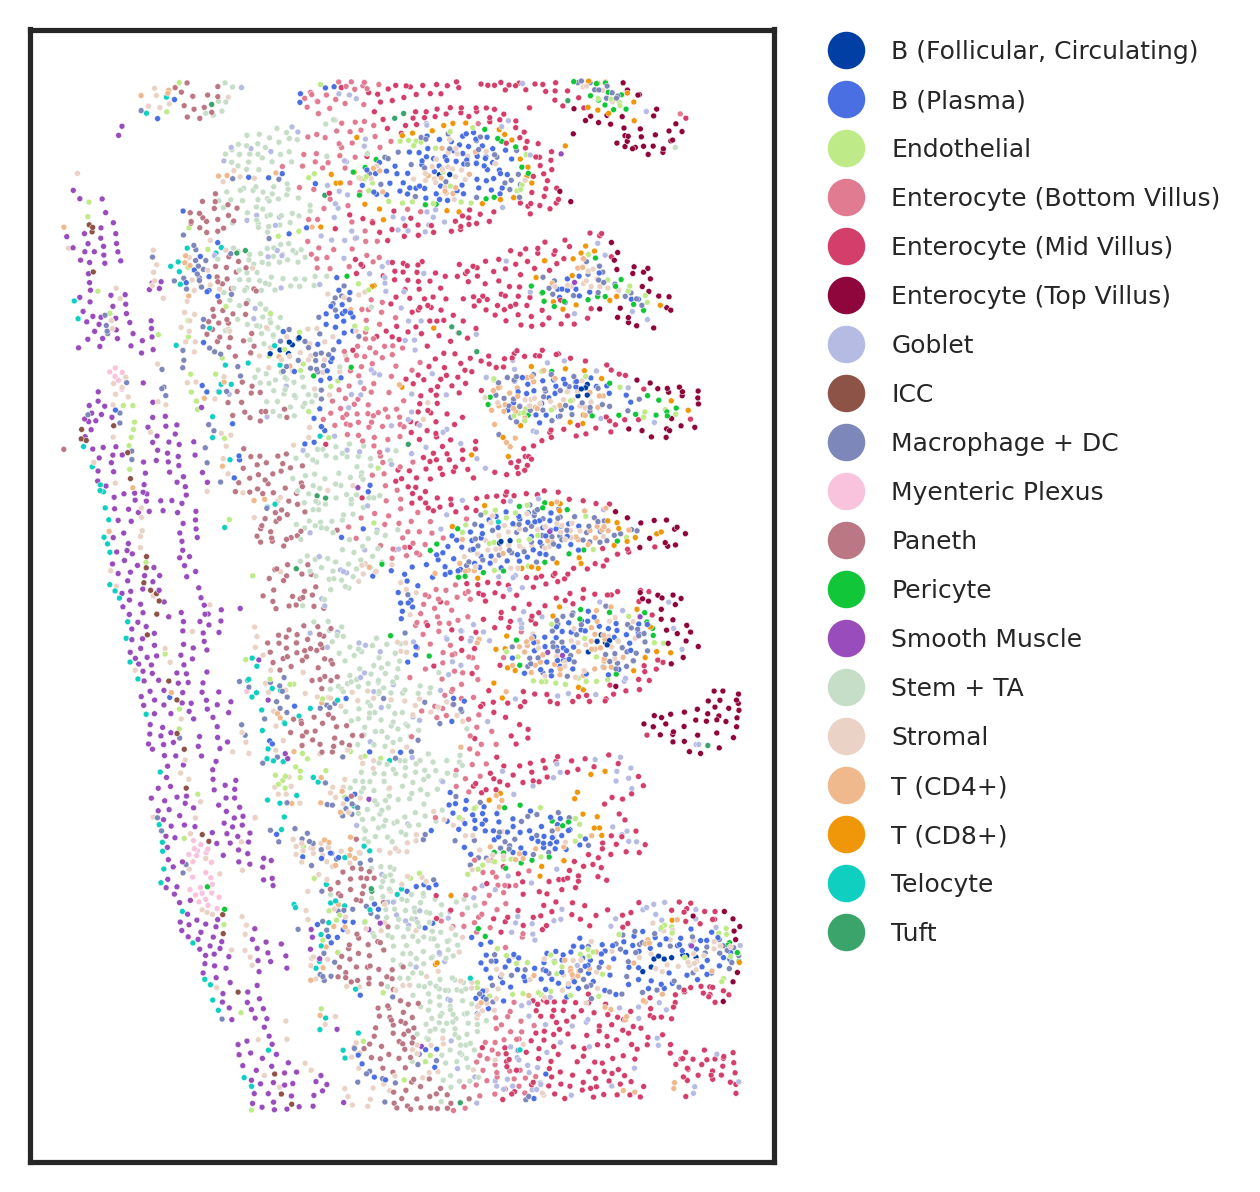

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

color_map={'B (Follicular, Circulating)': '#023fa5',
 'B (Plasma)': '#4a6fe3',
 'Endothelial': '#BEEA88',
 'Enterocyte (Bottom Villus)': '#e07b91',
 'Enterocyte (Mid Villus)': '#d33f6a',
 'Enterocyte (Top Villus)': '#8e063b',
 'Goblet': '#b5bbe3',
 'ICC': '#8D5346',
 'Macrophage + DC': '#7d87b9',
 'Myenteric Plexus': '#F9C3DD',
 'Paneth': '#bb7784',
 'Pericyte': '#11c638',
 'Smooth Muscle': '#994DBD',
 'Stem + TA': '#c6dec7',
 'Stromal': '#ead3c6',
 'T (CD4+)': '#f0b98d',
 'T (CD8+)': '#ef9708',
 'Telocyte': '#0fcfc0',
 'Tuft': '#3BA46B'}

sns.set(rc={"figure.dpi":300,'figure.figsize':(3.2, 5)}, font_scale=1)
sns.set_theme(style='white', palette='pastel')
g=sns.scatterplot(data=obs, x="x", y="y", hue="leiden_final", palette=color_map, s=2)
g.set_xlabel
g.set_xlabel("")
g.set_ylabel("")
g.set_yticks([])
g.set_xticks([])

from matplotlib.patches import Patch
lut = color_map
handles=[Line2D([0], [0], marker='o', color='w', markerfacecolor=lut[name], markersize=10) for name in sorted(lut)]
plt.legend(handles, sorted(lut), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1, frameon=False, fontsize=6, labelspacing=1)

### Configuration view (components)

In [12]:
# reinstall numpy to avoid the error
!pip install numpy==1.21.6


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


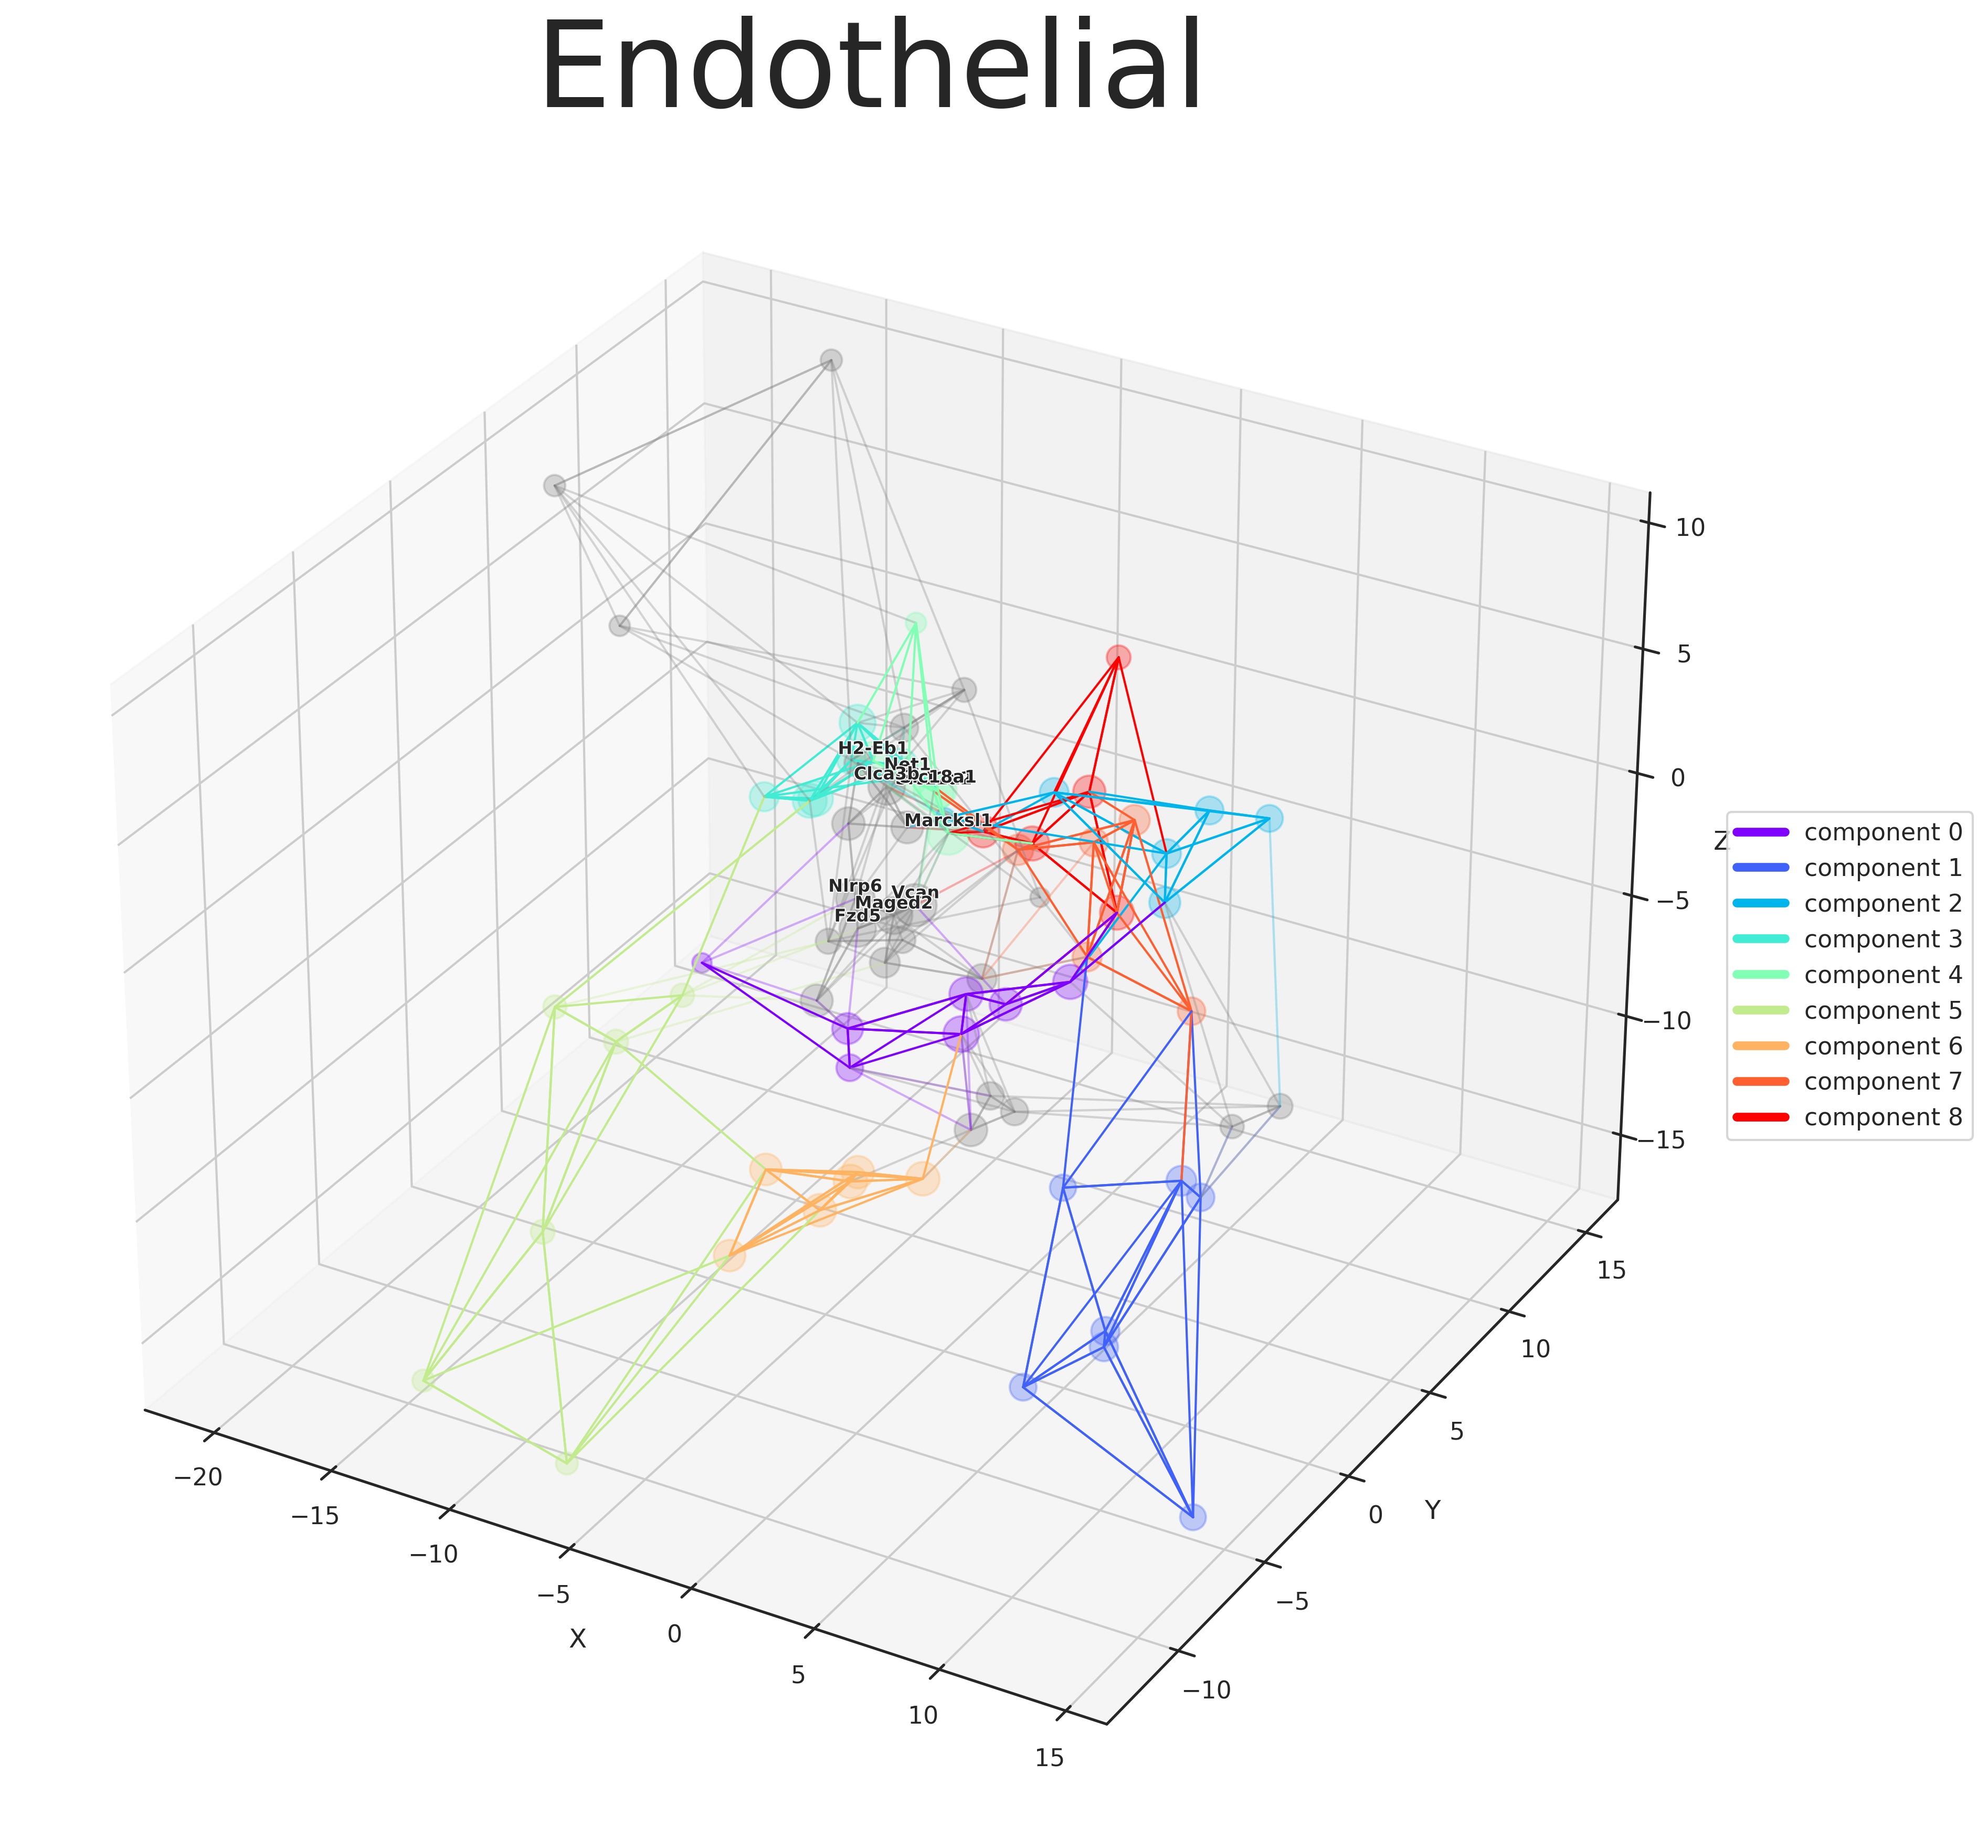

<Figure size 960x1500 with 0 Axes>

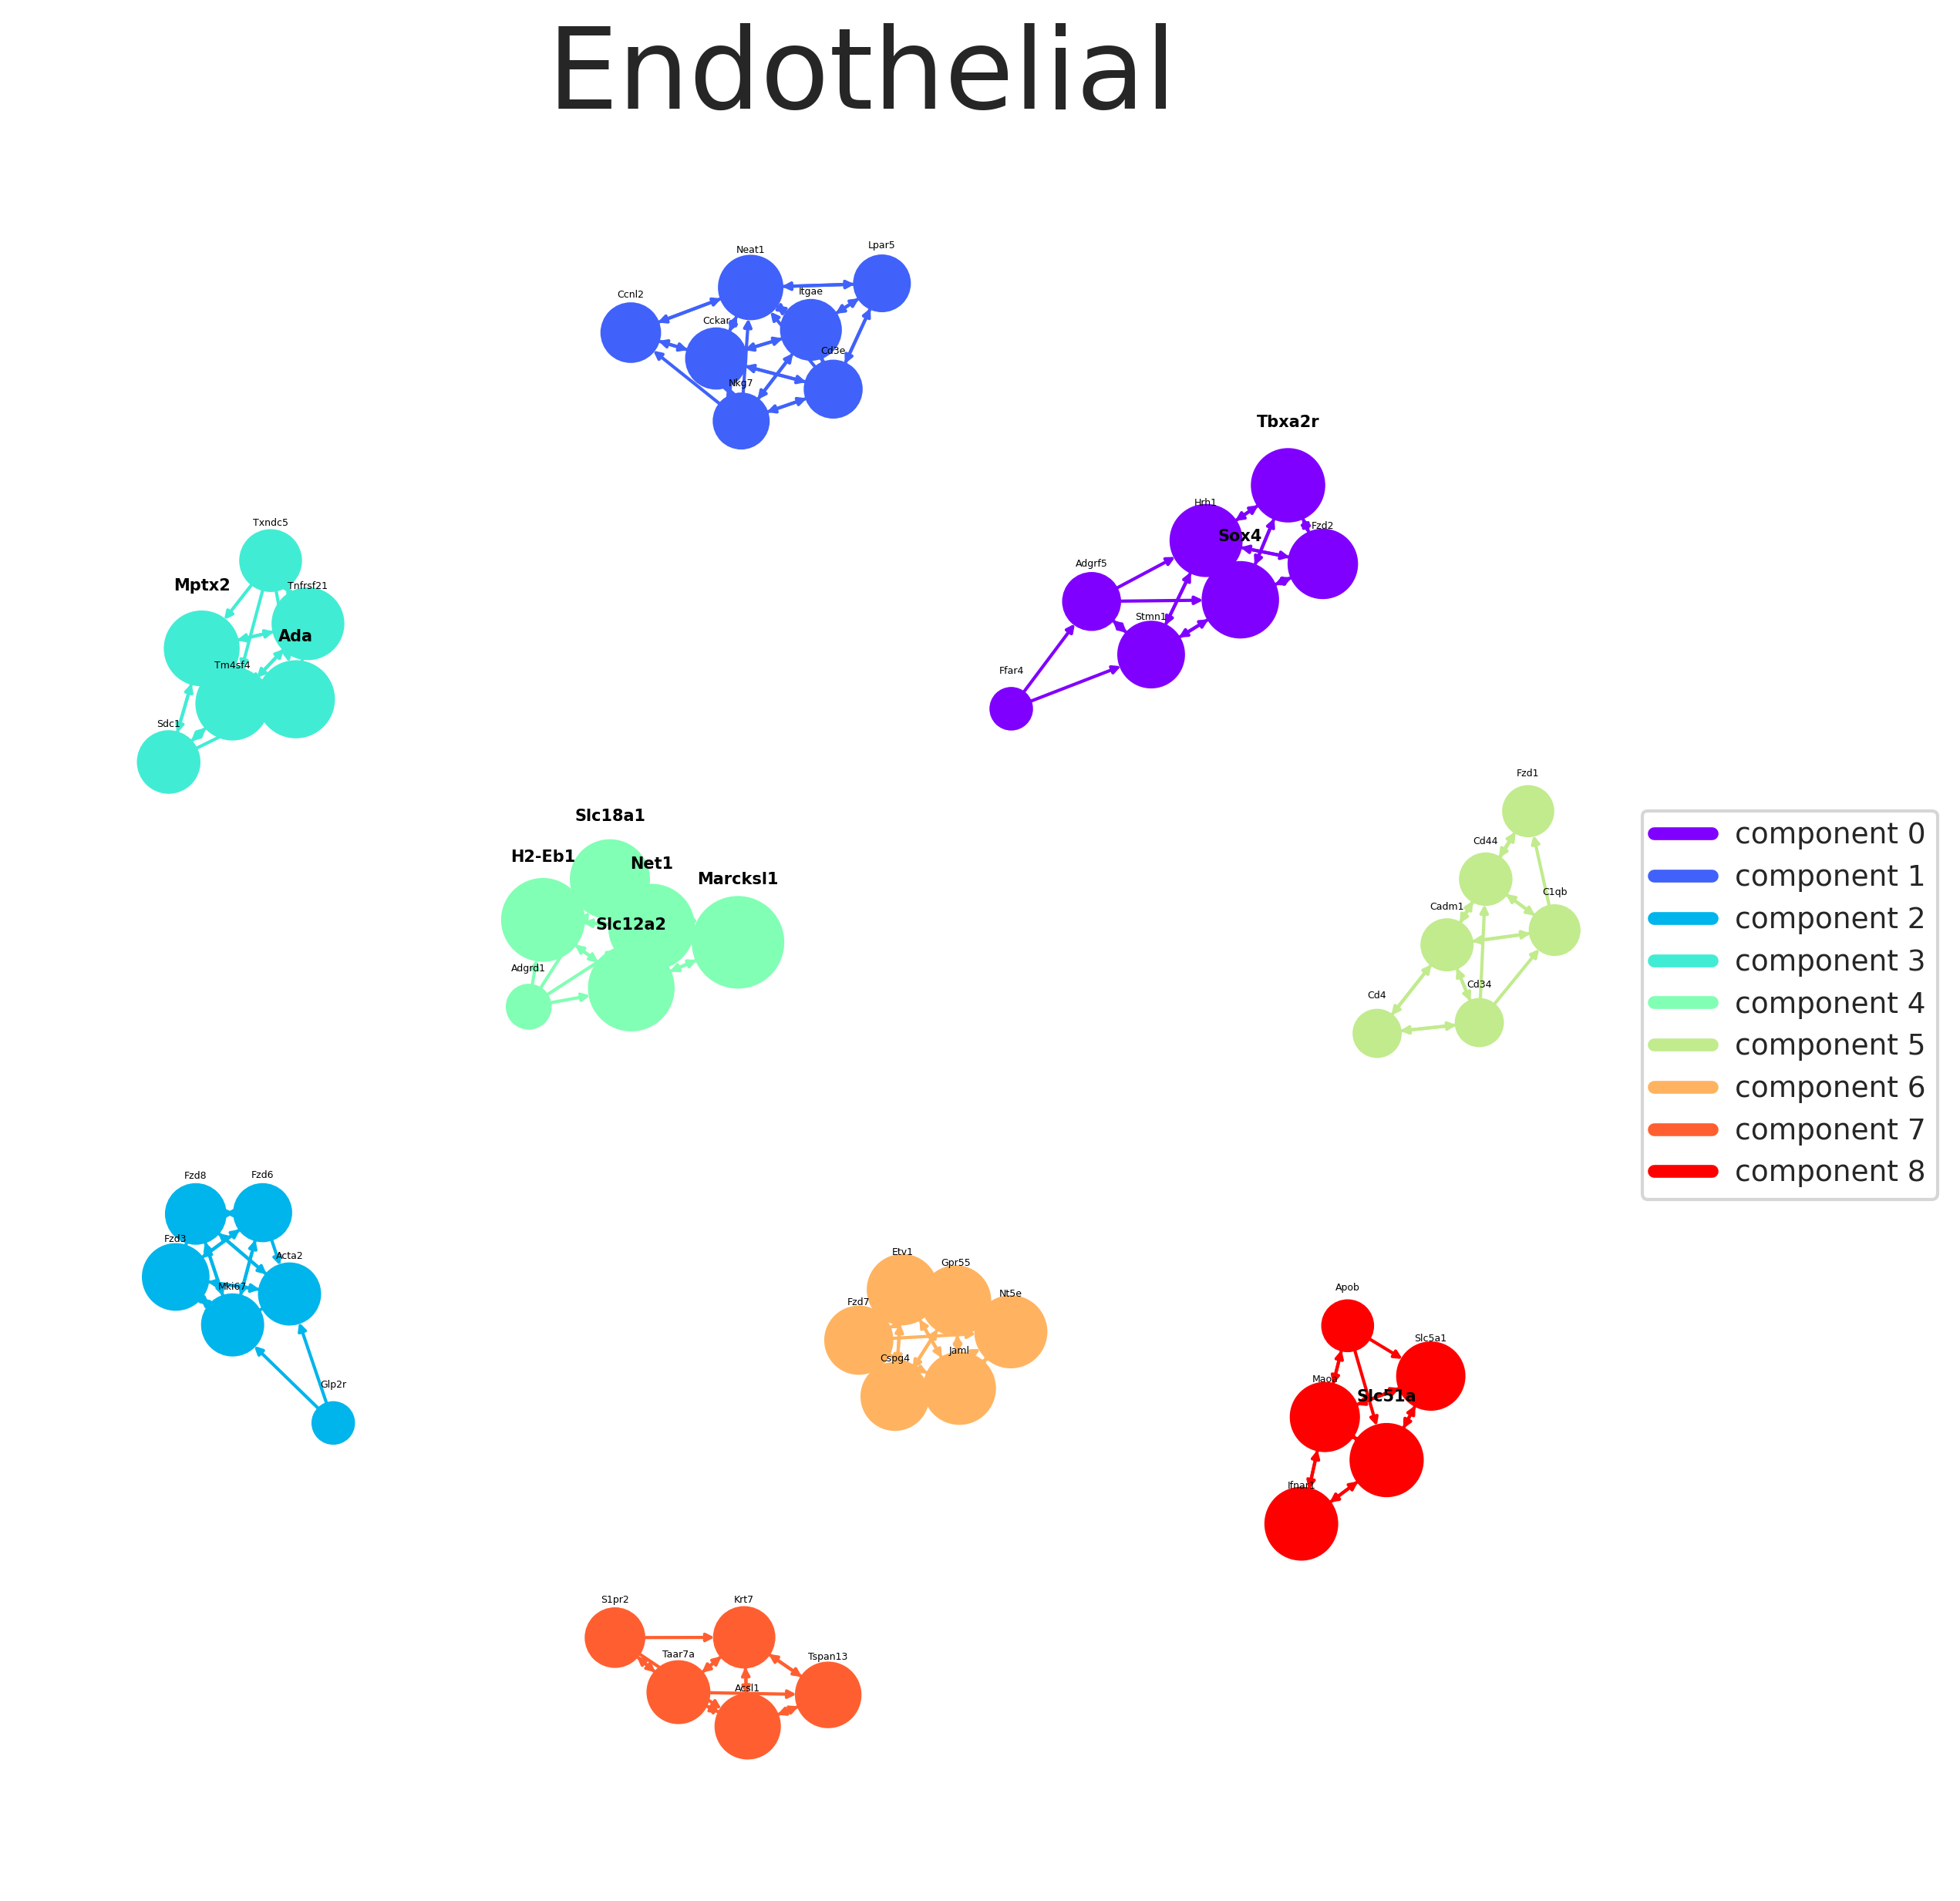

<Figure size 960x1500 with 0 Axes>

In [11]:
import networkx as nx
node_coords = adatas['Endothelial'].uns['F']

G = nx.DiGraph()
for node in node_coords.T:
    G.add_node(node, pos=node_coords.loc[node])

G_KNN = cplot.connect_edge_knn(G, k=5)
cplot.draw_5NN(G_KNN, title='Endothelial', save_path='./demo/merfish_ileum/results/Endothelial/')

### RMSD distance matrix

In [33]:
D_ileum = cc.RMSD_distance_matrix(adatas, ngene=19, compare_method='pair', norm_method=None)

100%|██████████| 18/18 [00:00<00:00, 162.25it/s]


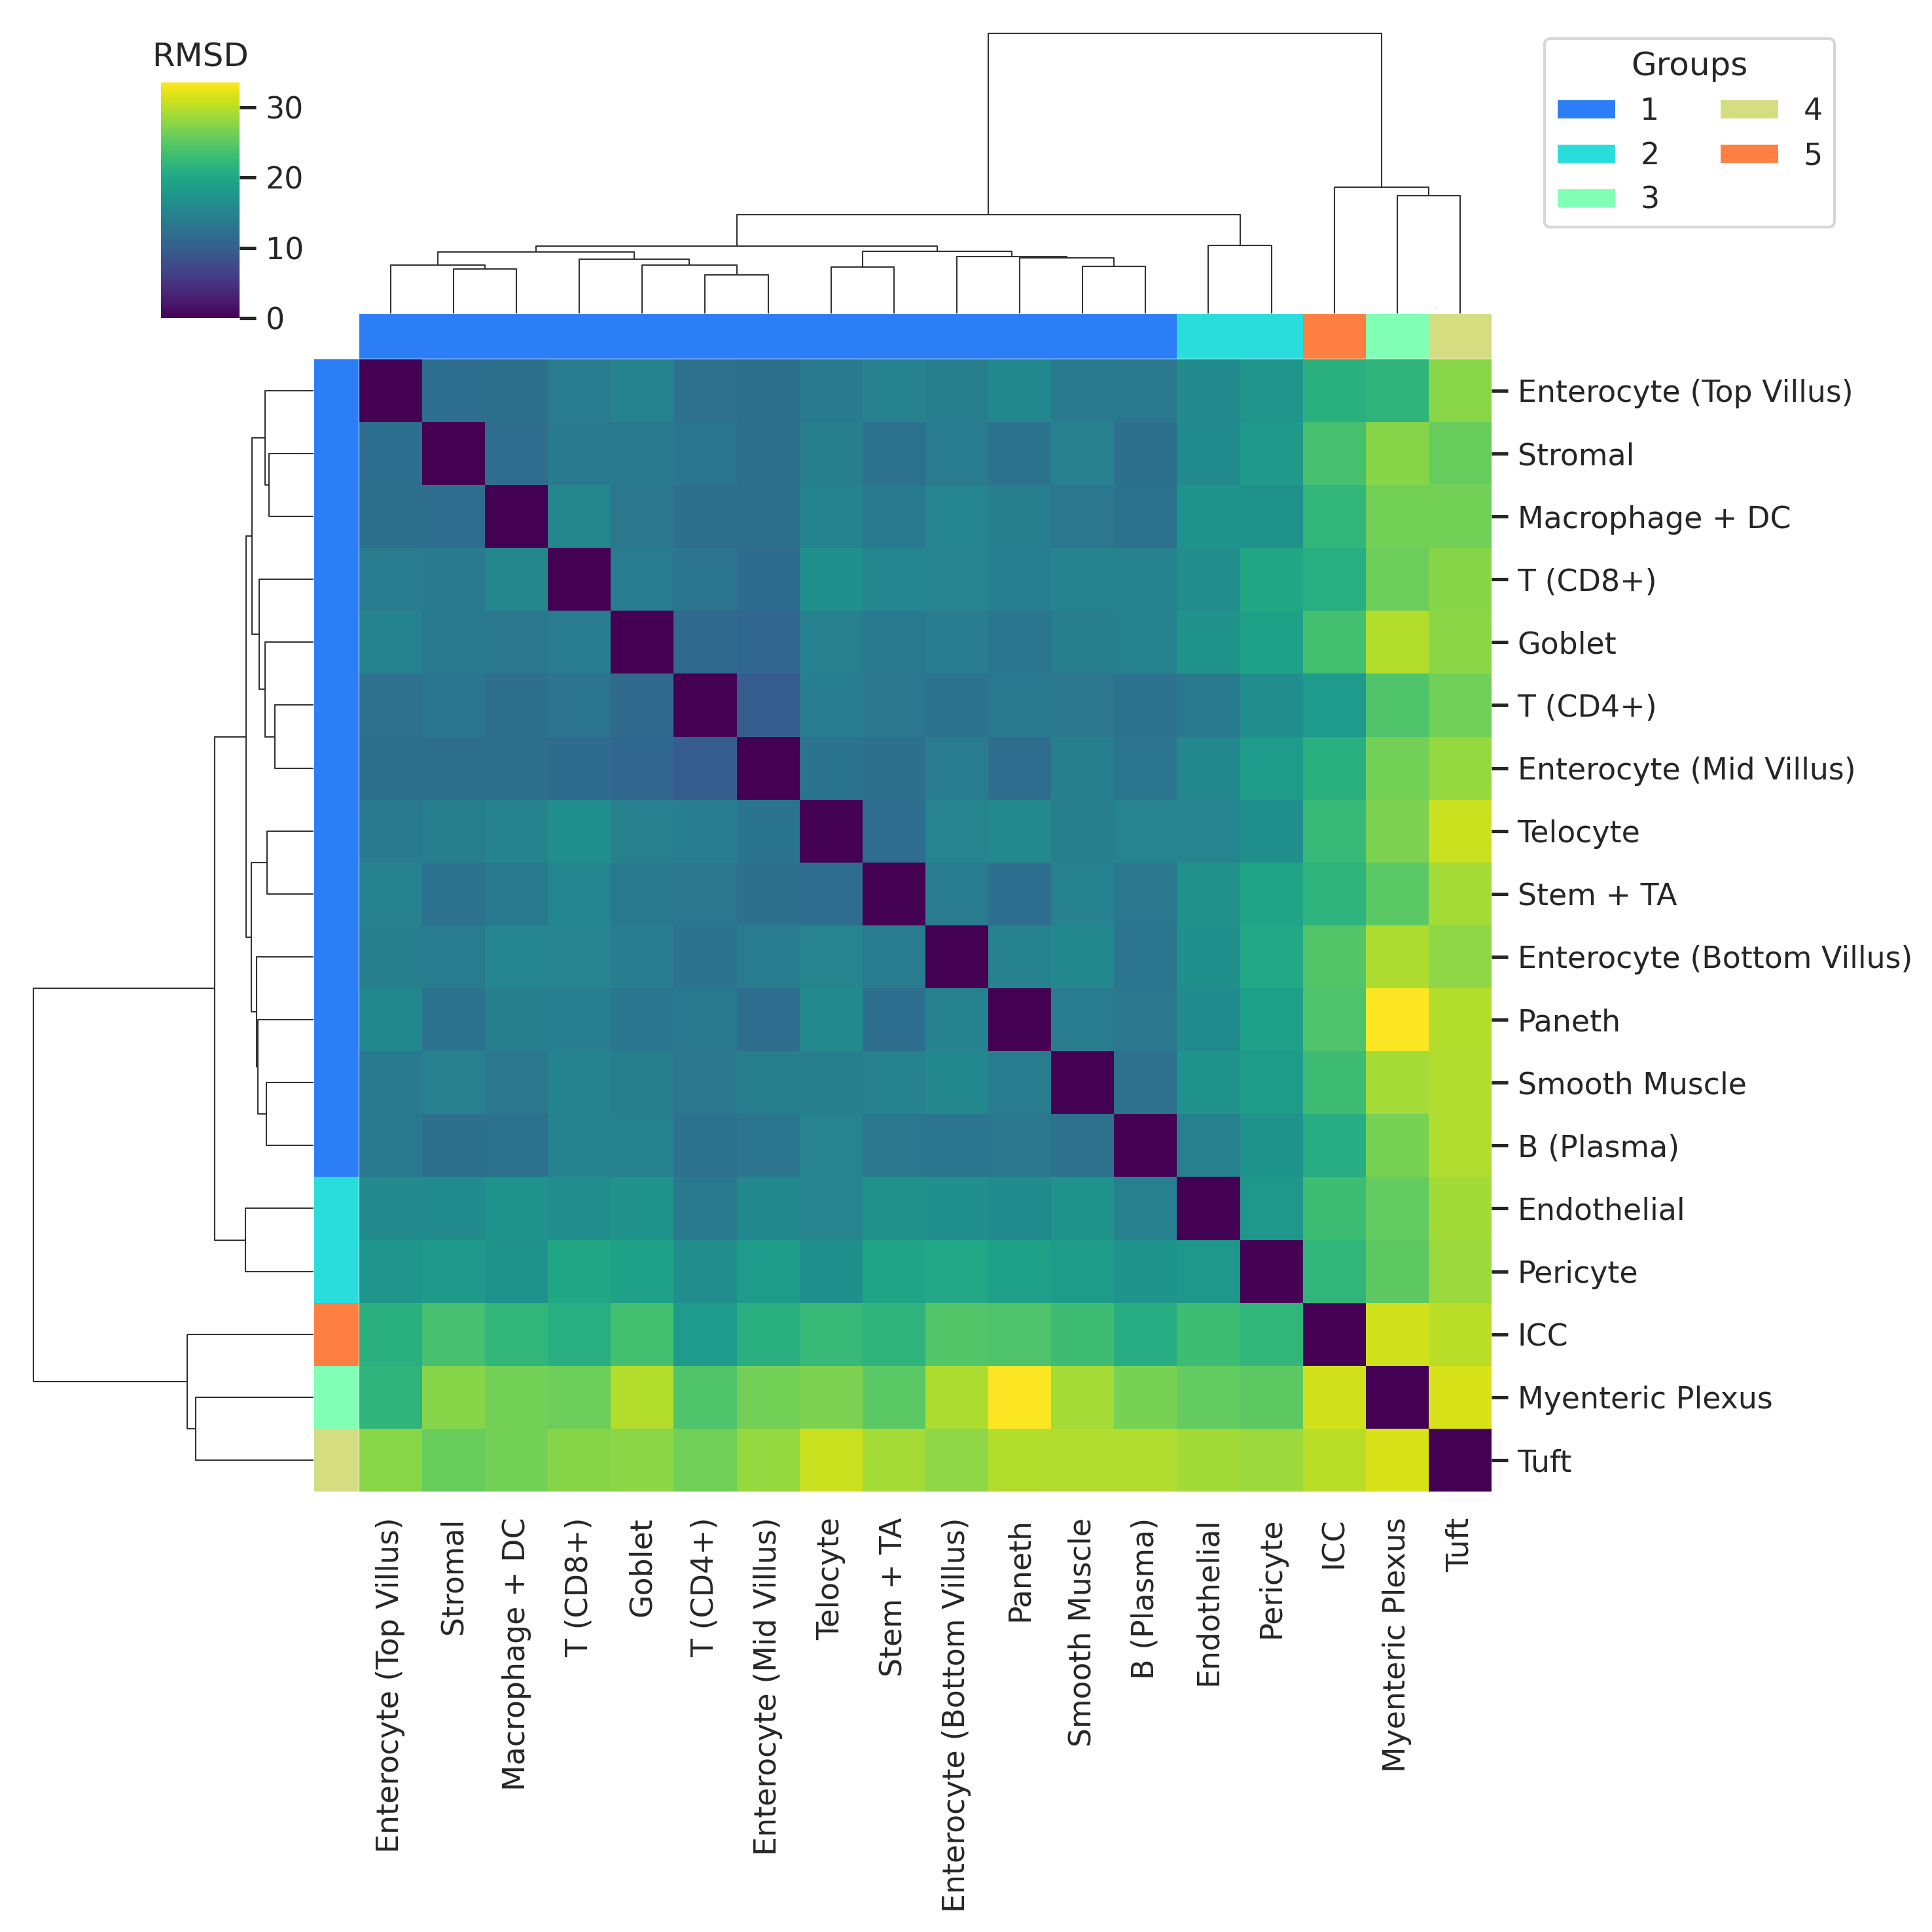

In [34]:
cplot.plot_RMSD_heatmap(D_ileum, labels=list(adatas.keys()), cmap='viridis', method='ward', cthresh = 30, dpi=300, 
                cbbox=(.09, .83, .04, .12), lgbox=(0.94, 0.97, .01, .01), ticks=[0,10,20,30,40])